### i) Import packages

In [1]:
import pandas as pd 
import numpy as np
import scipy as sp
import string, re
import nltk
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer, CountVectorizer
from sklearn import naive_bayes,metrics, linear_model,svm, grid_search
import time,random
import operator
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import sklearn.utils

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import style
plt.style.use('ggplot')

In [2]:
# Import nltk stopwords and lemmatizer
stop_list = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()
punctuation = list(string.punctuation)
stop_list = stop_list + punctuation +["rt", 'url']

### ii) Preprocess data

In [3]:
# Read kaggle data set from .csv-file
data_wneutral = pd.read_csv("Sentiment.csv")
data = data_wneutral[data_wneutral['sentiment'] !='Neutral']
classifier = []

In [4]:
# Preprocess of tweet-text-column: delete hashes, take out links, delete punctuation

def preprocess(tweet):
    if type(tweet)!=type(2.0):
        tweet = tweet.lower()
                
        #no difference between data set 
        tweet = tweet.replace("#bernieorbust", "positive")
        tweet = tweet.replace("#imwithher", "positive")
        tweet = tweet.replace("#votetrump2016", "positive")
        tweet = tweet.replace("#onlytrump", "positive")
        tweet = tweet.replace("#notmeus", "positive")
        tweet = tweet.replace("#stillsanders", "positive")
        tweet = tweet.replace("#hillarybros", "positive")
        tweet = tweet.replace("#latinos4bernie", "positive")
        tweet = tweet.replace("#americafirst", "positive")
        tweet = tweet.replace("#singsing4hillary", "positive")
        tweet = tweet.replace("#hillary2016pres", "positive")
        tweet = tweet.replace("#bernietheman", "positive") 
        tweet = tweet.replace("#america1st", "positive")
        tweet = tweet.replace("#teamtrump", "positive")
        tweet = tweet.replace("#antiwar", "positive")
        tweet = tweet.replace("#wearebernie", "positive")
        tweet = tweet.replace("#sheswithus", "positive") 
        tweet = tweet.replace("#empowering", "positive") 
        
        tweet = tweet.replace("#bernielaheadquarters", "positive")
        tweet = tweet.replace("#votebernie", "positive")    
        tweet = tweet.replace("#calibernication", "positive")
        tweet = tweet.replace("#teamamerica", "positive")
        
        tweet = tweet.replace("#vote4hillary", "positive")
        tweet = tweet.replace("#berniestrong", "positive")
            
        tweet = tweet.replace("#vivabernie", "positive")
        
        tweet = tweet.replace("#bernieforpresident", "positive")
        tweet = tweet.replace("#imwithhillary", "positive")    
        tweet = tweet.replace("#berniebus", "positive")      
        tweet = tweet.replace("#latinosforhillary", "positive")                               
        tweet = tweet.replace("#trumptractor", "positive")    
                                      
        tweet = tweet.replace("#bernieforpresident", "positive")
                            
        tweet = " hashtag".join(tweet.split('#'))
        tweet = re.sub('((www\.[^\s]+)|(https://[^\s]+))','URL',tweet)
        tweet = re.sub("http\S+", "URL", tweet)
        tweet = re.sub("https\S+", "URL", tweet)
        tweet = re.sub('@[^\s]+','AT_USER',tweet)
        tweet = re.sub(r'[0-9]*','',tweet)
        tweet = re.sub(r'@[a-zA-Z0-9]*', '', tweet)
        tweet = tweet.replace("AT_USER","")
        tweet = tweet.replace("URL","")
        tweet = tweet.replace(".","")
        tweet = tweet.replace('\"',"")
        tweet = tweet.replace('&amp',"")
      
        
        # Replace smileys with polarity
        tweet = tweet.replace(":-D", "positive")
        tweet = tweet.replace(":D", "positive")
        tweet = tweet.replace(":-)", "positive")
        tweet = tweet.replace(":)", "positive")
        tweet = tweet.replace("=D", "positive")
        tweet = tweet.replace("xD", "positive")
        tweet = tweet.replace("(^^)", "positive")
        tweet = tweet.replace("<3", "positive")
        tweet = tweet.replace("(L)", "positive")
        tweet = tweet.replace(":-(", "negative")
        tweet = tweet.replace(":(", "negative")
        tweet = tweet.replace(":'(", "negative")
        tweet = tweet.replace(":'-(", "negative")
        tweet = tweet.replace(":$", "negative")
        tweet = tweet.replace(":-$", "negative")
        tweet = tweet.replace(":-/", "negative")
        tweet  = " ".join([word for word in tweet.split(" ") if word not in stop_list])
        tweet  = " ".join([word for word in tweet.split(" ") if re.search('^[a-z]+$', word)])
        tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet.split(" ")])
        tweet = re.sub('[\s]+', ' ', tweet)
        tweet = tweet.strip('\'"')

        
        
    else:
        tweet=''
    return tweet

data['processed_text'] = data.text.apply(preprocess)
categories = data.sentiment.unique()
categories  = categories.tolist()

C:\Users\Philipp\Anaconda3\lib\site-packages\ipykernel\__main__.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# cut data to 50/50 positive/negative  
data_pos = data[data['sentiment'] == 'Positive']
data_neg = data[data['sentiment'] == 'Negative']

In [6]:
#set seed 
np.random.seed(18)

In [7]:
#bootstrap data
data_for_refit = pd.concat([
            data_pos.loc[np.random.choice(data_pos.index, size = 5000, replace = True),:],
            data_neg.loc[np.random.choice(data_neg.index, size = 5000, replace = True),:],
        ])

In [8]:
#setting aside 1000 words 
choice_pos = np.random.choice(data_pos.index, size = 500, replace = False)
choice_neg = np.random.choice(data_neg.index, size = 500, replace = False)

data_test = pd.concat([data_pos.loc[choice_pos,:], data_neg.loc[choice_neg,:]])
data_train = pd.concat([data_pos.drop(choice_pos), data_neg.drop(choice_neg)])

In [9]:
# cut data to 50/50 positive/negative  
data_train_pos = data_train[data_train['sentiment'] == 'Positive']
data_train_neg = data_train[data_train['sentiment'] == 'Negative']

In [10]:
data_train_pos.shape

(1736, 22)

In [11]:
choice = np.random.choice(data_train_neg.index, size = 5000, replace = True)
data_neg_boot = data_train_neg.loc[choice,:]

In [12]:
choice = np.random.choice(data_train_pos.index, size = 5000, replace = True)

In [13]:
data_pos_boot = data_train_pos.loc[choice,:]

In [14]:
classifier 

[]

In [15]:
# bootstrap to 10.000
data_train = pd.concat([data_pos_boot, data_neg_boot])

In [16]:
#join bootstrapped data and 1000 set aside for testing
data = pd.concat([data_train, data_test])

In [17]:
from sklearn.cross_validation import PredefinedSplit

ps = PredefinedSplit(test_fold=np.concatenate((np.zeros(data_train.shape[0])-1, np.zeros(data_test.shape[0]))))

In [18]:
data['sentiment'].value_counts()

Positive    5500
Negative    5500
Name: sentiment, dtype: int64

In [19]:
#naming vectors for fitting
x = data.processed_text.values
y = data.sentiment.values

x_refit = data_for_refit.processed_text.values
y_refit = data_for_refit.sentiment.values

In [20]:
data.shape
#data

(11000, 22)

### iii) Prepare training and test set, display of output

In [24]:
# Split data set into training and test set
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2)

# Output to show performance
def benchmark(clf,xtrain,ytrain,xtest,ytest,categories,vec_name):
    print('* ' * 40)
    print("Training on "+ vec_name +" : ")
    print(clf)
    clf.fit(xtrain, ytrain)
    pred = clf.predict(xtest)
    score = metrics.accuracy_score(ytest, pred)
    print("Accuracy:   %0.3f" % score)
    print("Confusion Matrix:\n",confusion_matrix(pred, y_test),"\n")
    print("Classification Report:\n",metrics.classification_report(y_test, pred, target_names=categories))

### iv) Create feature vectors

In [25]:
# Define Vectorizers,imported from sklearn
vec_name = ['Count Vectorizer','Bigram Count Vectorizer','Hashing Vectorizer','Tfidf Vectorizer']
vectorizer=[]
# Count Vectorizer: simply counts word occurrence
vectorizer.append(CountVectorizer(min_df = 0.01,max_df = 0.5, stop_words = 'english', analyzer='word'))
# Bigram Count Vectorizer: ngrams with 1 and 2 elements are extracted, not only single words
vectorizer.append(CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1))
# Hashing Vectorizer: same count as simple count vectorizer, but less memory consumption
vectorizer.append(HashingVectorizer(stop_words='english', non_negative=True))
# TFIDF Vectorizer: computes tfidf for terms with document frequency between 0.01 and 0.5
vectorizer.append(TfidfVectorizer(min_df = 0.01, max_df = 0.5, sublinear_tf = True,stop_words = 'english'))

from nltk.stem.snowball import EnglishStemmer

stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stem_vectorizer = CountVectorizer(analyzer=stemmed_words, stop_words='english')
len(stem_vectorizer.fit(x, y).get_feature_names())


#from nltk.stem.snowball import EnglishStemmer
#
#stemmer = EnglishStemmer()
#analyzer = CountVectorizer().build_analyzer()
#
#def stemmed_words(doc):
#    return (stemmer.stem(w) for w in analyzer(doc))
#
#stem_vectorizer = CountVectorizer(analyzer=stemmed_words, stop_words='english')

###############
# first reading of crawled data - ALL data - also not-labeled
data_evaluation = pd.read_csv("Data2.csv", sep=";")
data_evaluation['processed_text'] = data_evaluation.text.apply(preprocess)
data_evaluation_nn = data_evaluation[data_evaluation.processed_text.notnull()]
z = data_evaluation_nn.processed_text.values

vocab = set(stem_vectorizer.fit(x).get_feature_names()).intersection(set(stem_vectorizer.fit(z).get_feature_names()))

vectorizer.append(CountVectorizer(analyzer=stemmed_words, stop_words='english', vocabulary=vocab))
vec_name.append('Count Vectorizer on combined vocabulary')


vec_index = 2
x_train_vec = vectorizer[vec_index].fit_transform(x_train)
x_train_vec
x_test_vec = vectorizer[vec_index].transform(x_test)

In [26]:
vec_name[vec_index]

'Hashing Vectorizer'

### v) Train classifiers
#### a) Multinomial Naive Bayes

In [28]:
gs_mnb = OneVsRestClassifier(naive_bayes.MultinomialNB())

parameters = [
        
    {
        "estimator__alpha": [0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
    } 
]
#cv = 3
gs_mnb = grid_search.GridSearchCV(gs_mnb,param_grid=parameters, scoring = 'accuracy', cv = ps, verbose = 10, refit = False)

In [29]:
%%time
# Fit GridSearch
gs_mnb = gs_mnb.fit(vectorizer[vec_index].fit_transform(x), y)

#classifier_final = gs_log.best_estimator_

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] estimator__alpha=0.0001 .........................................
[CV] ................ estimator__alpha=0.0001, score=0.716000 -   0.0s
[CV] estimator__alpha=0.001 ..........................................


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s


[CV] ................. estimator__alpha=0.001, score=0.718000 -   0.0s
[CV] estimator__alpha=0.01 ...........................................
[CV] .................. estimator__alpha=0.01, score=0.721000 -   0.0s
[CV] estimator__alpha=0.1 ............................................
[CV] ................... estimator__alpha=0.1, score=0.729000 -   0.0s
[CV] estimator__alpha=1 ..............................................
[CV] ..................... estimator__alpha=1, score=0.743000 -   0.0s
[CV] estimator__alpha=10 .............................................


[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.4s


[CV] .................... estimator__alpha=10, score=0.739000 -   0.0s
[CV] estimator__alpha=100 ............................................
[CV] ................... estimator__alpha=100, score=0.706000 -   0.0s
[CV] estimator__alpha=1000 ...........................................


[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.7s


[CV] .................. estimator__alpha=1000, score=0.663000 -   0.0s
[CV] estimator__alpha=10000 ..........................................
[CV] ................. estimator__alpha=10000, score=0.638000 -   0.0s
Wall time: 1.25 s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s finished


In [30]:
print(gs_mnb.best_params_)
print(gs_mnb.best_score_)


mnb_best = naive_bayes.MultinomialNB(alpha = 0.1)

{'estimator__alpha': 1}
0.743


#### b) Logistic Regression

In [32]:
logit = OneVsRestClassifier(linear_model.LogisticRegression())

parameters = [
        
    {
        "estimator__C": [0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
    } 
]
#cv = 3
gs_log = grid_search.GridSearchCV(logit,param_grid=parameters, scoring = 'accuracy', cv = ps, verbose = 10, refit = False)

In [34]:
%%time
# Fit GridSearch
gs_log = gs_log.fit(vectorizer[vec_index].fit_transform(x), y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] estimator__C=0.0001 .............................................
[CV] .................... estimator__C=0.0001, score=0.643000 -   0.1s
[CV] estimator__C=0.001 ..............................................


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.1s


[CV] ..................... estimator__C=0.001, score=0.685000 -   0.1s
[CV] estimator__C=0.01 ...............................................
[CV] ...................... estimator__C=0.01, score=0.720000 -   0.2s
[CV] estimator__C=0.1 ................................................
[CV] ....................... estimator__C=0.1, score=0.748000 -   0.3s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    1.1s


[CV] ......................... estimator__C=1, score=0.763000 -   0.7s
[CV] estimator__C=10 .................................................
[CV] ........................ estimator__C=10, score=0.753000 -   1.4s
[CV] estimator__C=100 ................................................
[CV] ....................... estimator__C=100, score=0.746000 -   3.3s
[CV] estimator__C=1000 ...............................................


[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    6.7s


[CV] ...................... estimator__C=1000, score=0.739000 -   6.8s
[CV] estimator__C=10000 ..............................................
[CV] ..................... estimator__C=10000, score=0.730000 -  13.7s
Wall time: 27.6 s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.3s finished


In [35]:
print(gs_log.best_score_)

0.763


In [36]:
print(gs_log.best_params_)

{'estimator__C': 1}


In [37]:
logit_best = gs_log.estimator.set_params(**gs_log.best_params_).fit(vectorizer[vec_index].fit_transform(x_refit), y_refit)

In [27]:
#GridSearch
svmrest = OneVsRestClassifier(SVC())

parameters = [
    {
        "estimator__C": [1,10,100],
        "estimator__kernel": ['poly'],
        "estimator__degree":[2, 3],
        "estimator__probability": [True],
        "estimator__verbose": [False],
    },
    {
        "estimator__C": [1,10,100],
        "estimator__kernel": ['linear', 'rbf'],
        "estimator__degree":[3],
        "estimator__probability": [True],
        "estimator__verbose": [False],
    },
]

gs = grid_search.GridSearchCV(svmrest, parameters, scoring = 'accuracy', cv = ps, verbose = 10)

In [28]:
%%time
# Fit GridSearch
gs = gs.fit(vectorizer[vec_index].fit_transform(x), y)

classifier_final = gs.best_estimator_

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] estimator__probability=True, estimator__kernel=poly, estimator__degree=2, estimator__C=1, estimator__verbose=False 
[CV]  estimator__probability=True, estimator__kernel=poly, estimator__degree=2, estimator__C=1, estimator__verbose=False, score=0.625000 -  45.2s
[CV] estimator__probability=True, estimator__kernel=poly, estimator__degree=3, estimator__C=1, estimator__verbose=False 


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   45.2s


[CV]  estimator__probability=True, estimator__kernel=poly, estimator__degree=3, estimator__C=1, estimator__verbose=False, score=0.666000 -  38.4s
[CV] estimator__probability=True, estimator__kernel=poly, estimator__degree=2, estimator__C=10, estimator__verbose=False 
[CV]  estimator__probability=True, estimator__kernel=poly, estimator__degree=2, estimator__C=10, estimator__verbose=False, score=0.625000 -  43.8s
[CV] estimator__probability=True, estimator__kernel=poly, estimator__degree=3, estimator__C=10, estimator__verbose=False 
[CV]  estimator__probability=True, estimator__kernel=poly, estimator__degree=3, estimator__C=10, estimator__verbose=False, score=0.598000 -  35.4s
[CV] estimator__probability=True, estimator__kernel=poly, estimator__degree=2, estimator__C=100, estimator__verbose=False 


[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:  2.7min


[CV]  estimator__probability=True, estimator__kernel=poly, estimator__degree=2, estimator__C=100, estimator__verbose=False, score=0.625000 -  39.6s
[CV] estimator__probability=True, estimator__kernel=poly, estimator__degree=3, estimator__C=100, estimator__verbose=False 
[CV]  estimator__probability=True, estimator__kernel=poly, estimator__degree=3, estimator__C=100, estimator__verbose=False, score=0.602000 -  38.1s
[CV] estimator__probability=True, estimator__kernel=linear, estimator__degree=3, estimator__C=1, estimator__verbose=False 
[CV]  estimator__probability=True, estimator__kernel=linear, estimator__degree=3, estimator__C=1, estimator__verbose=False, score=0.752000 -  24.4s
[CV] estimator__probability=True, estimator__kernel=rbf, estimator__degree=3, estimator__C=1, estimator__verbose=False 


[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:  4.4min


[CV]  estimator__probability=True, estimator__kernel=rbf, estimator__degree=3, estimator__C=1, estimator__verbose=False, score=0.707000 -  42.4s
[CV] estimator__probability=True, estimator__kernel=linear, estimator__degree=3, estimator__C=10, estimator__verbose=False 
[CV]  estimator__probability=True, estimator__kernel=linear, estimator__degree=3, estimator__C=10, estimator__verbose=False, score=0.751000 -  24.9s
[CV] estimator__probability=True, estimator__kernel=rbf, estimator__degree=3, estimator__C=10, estimator__verbose=False 
[CV]  estimator__probability=True, estimator__kernel=rbf, estimator__degree=3, estimator__C=10, estimator__verbose=False, score=0.707000 -  43.0s
[CV] estimator__probability=True, estimator__kernel=linear, estimator__degree=3, estimator__C=100, estimator__verbose=False 
[CV]  estimator__probability=True, estimator__kernel=linear, estimator__degree=3, estimator__C=100, estimator__verbose=False, score=0.722000 -  33.3s
[CV] estimator__probability=True, estima

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:  7.5min
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  7.5min finished


Wall time: 8min 4s


In [29]:
svm_best = gs.best_estimator_
svm_best

OneVsRestClassifier(estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [30]:
print(gs.best_score_)

0.752


In [32]:
svm_best = gs.estimator.set_params(**gs.best_params_).fit(vectorizer[vec_index].fit_transform(x_refit), y_refit)

### vi) Read crawled tweets and preprocess text

In [36]:
# Choose final classifier to perform task
classifier_final = svm_best
#classifier_final = logit_best
#classifier_final = mnb_best


In [37]:
# Read crawled ALL tweets 
data_evaluation = pd.read_csv("Data2.csv", sep=";")
data_evaluation['processed_text'] = data_evaluation.text.apply(preprocess)

In [39]:
# Remove NaN from processed text values
data_evaluation_nn = data_evaluation[data_evaluation.processed_text.notnull()]

In [41]:
#looking at SVM words
vocab_class = classifier_final.predict(vectorizer[vec_index].fit_transform(vocab))

In [42]:
vocab_proba = classifier_final.predict_proba(vectorizer[vec_index].fit_transform(vocab))

In [43]:
bam = pd.concat([pd.Series(list(vocab), name = 'word'), pd.Series(vocab_class, name = 'sentiment'), pd.DataFrame(vocab_proba)], axis = 1)

In [44]:
bam.to_excel('bam.xlsx')

### vii) Perform classification

In [45]:
# Create feature vector from processed text values
z = data_evaluation_nn.processed_text.values
z_eval_vec = vectorizer[vec_index].transform(z)
# Predict sentiment for all tweets
pred = classifier_final.predict(z_eval_vec)
# Derive confidence score for sentiments
pred_proba = classifier_final.predict_proba(z_eval_vec)
pred_proba

array([[ 0.08607793,  0.91392207],
       [ 0.27000268,  0.72999732],
       [ 0.71341076,  0.28658924],
       ..., 
       [ 0.89377738,  0.10622262],
       [ 0.86660643,  0.13339357],
       [ 0.86660643,  0.13339357]])

In [46]:
# Append classified sentiment to dataframe data_evaluation_nn
data_evaluation_nn['sentiment'] = pd.Series(pred, index=data_evaluation_nn.index)
# Append confidence level for classified sentiment to dataframe data_evaluation_nn
data_evaluation_nn['confidence negative'] = pd.Series(pred_proba[:,0], index=data_evaluation_nn.index)
data_evaluation_nn['confidence positive'] = pd.Series(pred_proba[:,1], index=data_evaluation_nn.index)

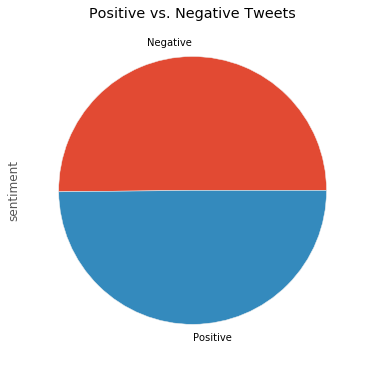

In [47]:
# Plot overall distribuation of positive vs. negative tweets
sent = data_evaluation_nn.sentiment.value_counts()
sent.plot(kind='pie', title = 'Positive vs. Negative Tweets', figsize=[6,6])

### ix) Export results

In [48]:
data_evaluation_nn = data_evaluation_nn[data_evaluation_nn.id.notnull()]

In [49]:
#formating "id"
#add two zeros after ####, delete #### before and after jpg, add dot before jpg
data_evaluation_nn.id = data_evaluation_nn.id.apply(lambda x: (x[0:11] + '00' + x[11:18] + '.jpg'))

In [50]:
#the following are the data labeled by hand - saved and combined by selma
true_labels = pd.read_csv("Data_LabelsSelma.csv", sep=";")

In [52]:
#formating id from hand labeld data
true_labels['id'] = true_labels['id'].str[0:11] + '00' + true_labels['id'].str[11:18] + '.jpg'
true_labels['true_sentiment'] = true_labels['Labels_Text'] 

In [53]:
true_labels['true_sentiment'].value_counts()

-1.0    101
 1.0     99
Name: true_sentiment, dtype: int64

In [54]:
true_labels.true_sentiment = true_labels.true_sentiment.astype('category')

In [57]:
true_labels['true_sentiment'].value_counts()

-1.0    101
 1.0     99
Name: true_sentiment, dtype: int64

In [59]:
data_evaluation_nn.sentiment = data_evaluation_nn.sentiment.astype('category').cat.codes
data_evaluation_nn.sentiment[data_evaluation_nn.sentiment == 0] = -1

C:\Users\Philipp\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [60]:
export = pd.merge(data_evaluation_nn, true_labels, on = 'id', how = 'left')

In [62]:
#accuracy 
from sklearn.metrics import accuracy_score
accuracy_score(export.loc[~export['true_sentiment'].isnull(),'true_sentiment'], export.loc[~export['true_sentiment'].isnull(),'sentiment'])

0.72499999999999998

In [63]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(export.loc[~export['true_sentiment'].isnull(),'true_sentiment'], export.loc[~export['true_sentiment'].isnull(),'sentiment'], labels = [-1, 1]))

             precision    recall  f1-score   support

         -1       0.75      0.68      0.72       101
          1       0.70      0.77      0.73        99

avg / total       0.73      0.72      0.72       200



In [64]:
print(confusion_matrix(export.loc[~export['true_sentiment'].isnull(),'true_sentiment'], export.loc[~export['true_sentiment'].isnull(),'sentiment'], labels = [-1, 1]))

[[69 32]
 [23 76]]


In [65]:
# Export results to CSV file
export2 = export[['id','sentiment','confidence positive','confidence negative','Labels_Text','Labels_Image','Labels_tog','true_sentiment','processed_text','text_x']]
export2.to_csv("results_after_presentation.csv", index=False)